# Q-learning or Q-network (QN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.0273733 , -0.17343435,  0.03084451,  0.28159943]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.5243542871057465 -2.9998205781922618


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [33]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(tf.multiply(actions_logits[:-1], actions_onehot[1:]), axis=1)
    #loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    #loss = tf.reduce_mean(tf.square(Qs[:-1] - targetQs[2:]))
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))    
    return actions_logits, loss

In [34]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [35]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [36]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [37]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(500, 4) actions:(500,)
2


In [38]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [39]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [40]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    memory.buffer.append([action, state, done])
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [41]:
state, reward, action

(array([-0.11292308, -0.57389744,  0.03724589,  0.66969117]), 1.0, 0)

In [42]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            memory.buffer.append([action, state, done])
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            dones = np.array([each[2] for each in batch])
            
            # Calculate targetQs/nextQs
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            Qs = np.max(actions_logits, axis=1)
            targetQs = Qs * (1 - dones.astype(float))
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                     model.states: states,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.9f}'.format(np.mean(loss_batch)),
              'Explore P: {:.9f}'.format(explore_p))
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn.ckpt')

Episode: 0 Total reward: 22.0 Average loss: 0.693147659 Explore P: 0.997824394
Episode: 1 Total reward: 30.0 Average loss: 0.693147242 Explore P: 0.994865362
Episode: 2 Total reward: 29.0 Average loss: 0.693147182 Explore P: 0.992013389
Episode: 3 Total reward: 30.0 Average loss: 0.693147242 Explore P: 0.989071764
Episode: 4 Total reward: 14.0 Average loss: 0.693147063 Explore P: 0.987702022
Episode: 5 Total reward: 12.0 Average loss: 0.693147123 Explore P: 0.986529484
Episode: 6 Total reward: 14.0 Average loss: 0.693147063 Explore P: 0.985163299
Episode: 7 Total reward: 10.0 Average loss: 0.693147123 Explore P: 0.984188623
Episode: 8 Total reward: 20.0 Average loss: 0.693147063 Explore P: 0.982242193
Episode: 9 Total reward: 20.0 Average loss: 0.693147063 Explore P: 0.980299652
Episode: 10 Total reward: 19.0 Average loss: 0.693147063 Explore P: 0.978457833
Episode: 11 Total reward: 20.0 Average loss: 0.693147063 Explore P: 0.976522853
Episode: 12 Total reward: 13.0 Average loss: 0.693

Episode: 104 Total reward: 35.0 Average loss: 0.693147182 Explore P: 0.805049950
Episode: 105 Total reward: 11.0 Average loss: 0.693147123 Explore P: 0.804175876
Episode: 106 Total reward: 25.0 Average loss: 0.693147123 Explore P: 0.802192916
Episode: 107 Total reward: 17.0 Average loss: 0.693147123 Explore P: 0.800847332
Episode: 108 Total reward: 18.0 Average loss: 0.693147063 Explore P: 0.799425087
Episode: 109 Total reward: 14.0 Average loss: 0.693147063 Explore P: 0.798320666
Episode: 110 Total reward: 11.0 Average loss: 0.693147123 Explore P: 0.797453990
Episode: 111 Total reward: 25.0 Average loss: 0.693147123 Explore P: 0.795487813
Episode: 112 Total reward: 15.0 Average loss: 0.693147004 Explore P: 0.794310465
Episode: 113 Total reward: 11.0 Average loss: 0.693147123 Explore P: 0.793448198
Episode: 114 Total reward: 13.0 Average loss: 0.693147063 Explore P: 0.792430377
Episode: 115 Total reward: 33.0 Average loss: 0.693147123 Explore P: 0.789852612
Episode: 116 Total reward: 1

Episode: 206 Total reward: 31.0 Average loss: 0.079265825 Explore P: 0.561865823
Episode: 207 Total reward: 39.0 Average loss: 0.077474736 Explore P: 0.559717738
Episode: 208 Total reward: 92.0 Average loss: 0.073487222 Explore P: 0.554683528
Episode: 209 Total reward: 135.0 Average loss: 0.086570702 Explore P: 0.547379712
Episode: 210 Total reward: 146.0 Average loss: 0.122860804 Explore P: 0.539590964
Episode: 211 Total reward: 96.0 Average loss: 0.142314628 Explore P: 0.534531217
Episode: 212 Total reward: 30.0 Average loss: 0.228164703 Explore P: 0.532959981
Episode: 213 Total reward: 101.0 Average loss: 0.234307438 Explore P: 0.527704669
Episode: 214 Total reward: 27.0 Average loss: 0.400645494 Explore P: 0.526308752
Episode: 215 Total reward: 136.0 Average loss: 0.223715901 Explore P: 0.519334485
Episode: 216 Total reward: 18.0 Average loss: 0.069683582 Explore P: 0.518418508
Episode: 217 Total reward: 21.0 Average loss: 0.047941133 Explore P: 0.517351949
Episode: 218 Total rewar

Episode: 307 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.124286099
Episode: 308 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.122023082
Episode: 309 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.119804877
Episode: 310 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.117630595
Episode: 311 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.115499366
Episode: 312 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.113410339
Episode: 313 Total reward: 151.0 Average loss: 0.693147063 Explore P: 0.111860573
Episode: 314 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.109843598
Episode: 315 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.107866562
Episode: 316 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.105928675
Episode: 317 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.104029160
Episode: 318 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.102167258
Episode: 319 Tot

Episode: 407 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.025542916
Episode: 408 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.025235145
Episode: 409 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.024933469
Episode: 410 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.024637767
Episode: 411 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.024347919
Episode: 412 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.024063812
Episode: 413 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.023785329
Episode: 414 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.023512362
Episode: 415 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.023244799
Episode: 416 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.022982534
Episode: 417 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.022725463
Episode: 418 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.022473482
Episode: 419 Tot

Episode: 507 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.012103505
Episode: 508 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.012061853
Episode: 509 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.012021025
Episode: 510 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.011981006
Episode: 511 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.011941780
Episode: 512 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.011903330
Episode: 513 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.011865641
Episode: 514 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.011828699
Episode: 515 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.011792489
Episode: 516 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.011756995
Episode: 517 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.011722204
Episode: 518 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.011688102
Episode: 519 Tot

Episode: 607 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010284678
Episode: 608 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010279041
Episode: 609 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010273516
Episode: 610 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010268100
Episode: 611 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010262791
Episode: 612 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010257588
Episode: 613 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010252487
Episode: 614 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010247488
Episode: 615 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010242587
Episode: 616 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010237783
Episode: 617 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010233075
Episode: 618 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010228460
Episode: 619 Tot

Episode: 707 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010038527
Episode: 708 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010037764
Episode: 709 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010037016
Episode: 710 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010036283
Episode: 711 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010035565
Episode: 712 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010034861
Episode: 713 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010034170
Episode: 714 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010033494
Episode: 715 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010032831
Episode: 716 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010032180
Episode: 717 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010031543
Episode: 718 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010030919
Episode: 719 Tot

Episode: 807 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010005214
Episode: 808 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010005111
Episode: 809 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010005010
Episode: 810 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010004910
Episode: 811 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010004813
Episode: 812 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010004718
Episode: 813 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010004624
Episode: 814 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010004533
Episode: 815 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010004443
Episode: 816 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010004355
Episode: 817 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010004269
Episode: 818 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010004184
Episode: 819 Tot

Episode: 907 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000706
Episode: 908 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000692
Episode: 909 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000678
Episode: 910 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000665
Episode: 911 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000651
Episode: 912 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000638
Episode: 913 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000626
Episode: 914 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000613
Episode: 915 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000601
Episode: 916 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000589
Episode: 917 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000578
Episode: 918 Total reward: 200.0 Average loss: 0.693147123 Explore P: 0.010000566
Episode: 919 Tot

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

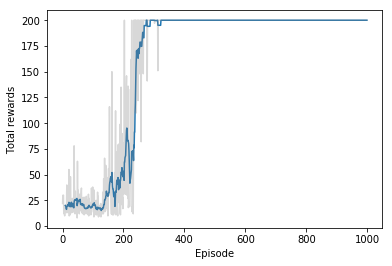

In [47]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

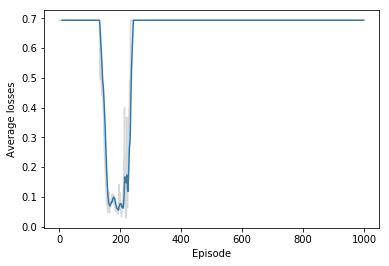

In [48]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [49]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.